# See which region is enriched?
Charlene did region based enrichment quick and dirty

In [1]:
import sys
sys.path.append('/home/hsher/projects/Metadensity')
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt

encode_data = pd.read_pickle('~/projects/eclip_encode_id.pickle')
eclip_bam = pd.read_csv('/home/hsher/projects/RBP_annot/ENCODE_FINAL_ANNOTATIONS.uidsonly.txt.manifesthg38.txt', sep = '\t', header= 0)

# join data
encode_data = pd.merge(eclip_bam[['uID', 'RBP', 'Cell line']], encode_data, left_on = ['RBP', 'Cell line'], right_on = ['RBP', 'cell_line'])

In [2]:
HNRNPC = eCLIP()
HNRNPC.RBP_centric_approach(encode_data.loc[(encode_data['RBP'] == 'HNRNPC')&(encode_data['Cell line'] == 'HepG2')])

finding negative/positive examples


# fetching total reads mapped

In [3]:
HNRNPC.read_densities['rep1'].total_mapped()

20283708

In [4]:
HNRNPC.read_densities['rep2'].total_mapped()

30721918

In [5]:
HNRNPC.read_densities['ctrl'].total_mapped()

11838172

# fetching regional reads

In [6]:
introns = BedTool('/home/hsher/gencode_coords/gencode_intron.gff3')

In [7]:
HNRNPC.read_densities['rep1'].bam.count(contig = 'chr1', start=12227, stop = 212612)

190

In [8]:
HNRNPC.read_densities['ctrl'].bam.count(contig = 'chr1', start=12227, stop = 212612)

83

# putting all stuffs together

In [9]:
from scipy.stats import poisson
def poission_pval(smi_total, smi_region, ip_total, ip_region):
    rate = smi_region / smi_total
    x = ip_total
    mu = rate*x
    
    
    # get pvalue
    return 1-poisson.cdf(ip_region, mu = mu)

def poission_critical_val(smi_total, smi_region, ip_total, alpha = 0.05):
    rate = smi_region / smi_total
    x = ip_total
    mu = rate*x
    
    percentile = 1-alpha
    
    return poisson.ppf(percentile, mu = mu)
    
    
    

# run on 10000 introns for HNRNPC rep1

In [10]:
df = pd.DataFrame(columns = ['chrom', 'start', 'stop', 'ID', '.', 'strand', 'pval', 'fold'])
ip_total = HNRNPC.read_densities['rep1'].total_mapped()
smi_total = HNRNPC.read_densities['ctrl'].total_mapped()
nrow = 0
for i in introns[:10000]:
    
    ip_region = HNRNPC.read_densities['rep1'].bam.count(contig = i.chrom, start=i.start, stop = i.stop)
    
    if ip_region > 0:
        # if more than 1 read in that intron
        smi_region = HNRNPC.read_densities['ctrl'].bam.count(contig = i.chrom, start=i.start, stop = i.stop)
        if smi_region > 0:
            pval = poission_pval(smi_total, smi_region, ip_total, ip_region)
            fold_enrich = (ip_region/ip_total)/(smi_region/smi_total)
            
            if pval < 0.05:
                bed = [i.chrom, i.start,i.stop,i.attrs['ID'],".",i.strand, pval, fold_enrich]
                
                df.loc[nrow] = bed
                nrow += 1
                
    
    

In [11]:
df.shape

(2010, 8)

Text(0, 0.5, 'No. intron')

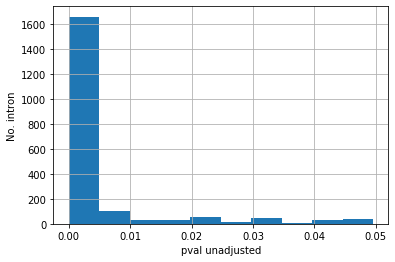

In [12]:
df['pval'].hist()
plt.xlabel('pval unadjusted')
plt.ylabel('No. intron')

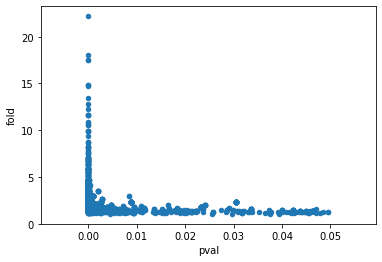

In [13]:
df.plot(kind = 'scatter', x = 'pval', y = 'fold')

# multiple hypothesis correction

In [14]:
df.head()

,chrom,start,stop,ID,.,strand,pval,fold
0,chr1,18366,24737,ENST00000488147.1,.,-,2.792419e-05,3.112691
1,chr1,24891,29533,ENST00000488147.1,.,-,4.081088e-04,4.085407
2,chr1,92240,112699,ENST00000466430.5,.,-,2.395670e-04,3.209963
3,chr1,188902,195262,ENST00000623083.4,.,-,4.057374e-10,2.167767
4,chr1,268655,347981,ENST00000441866.2,.,-,4.220385e-02,1.264531


In [15]:
# bonferrni correction
df['padj'] = df['pval']* 10000

In [16]:
sum(df['padj'] < 0.05)

1174

In [17]:
sum(df['padj'] < 10**(-3)) # the threshold suggested by eCLIP paper

1003

In [18]:
df.loc[(df['padj']< 10**(-3)) & (df['fold'] > 8)].shape # filter by both p-val and fold change

(31, 9)

In [19]:
filtered = df.loc[(df['padj']< 10**(-3)) & (df['fold'] > 8)]

In [20]:
signi_intron = BedTool.from_dataframe(filtered)

# run 10000 feature and see if distribution fit what we know

In [21]:
features = BedTool('/home/hsher/gencode_coords/gencode_combine_sorted.gff3')
def run_poission(e, rep, features = features, n_upper = 10000):
    # create dataframe to save result
    df = pd.DataFrame(columns = ['chrom', 'start', 'stop', 'ID', '.', 'strand', 'pval', 'fold'])
    
    # fetch total reads
    
    ip_total = e.read_densities[rep].total_mapped()
    smi_total = e.read_densities['ctrl'].total_mapped()
    
    # run for all regions
    nrow = 0
    for i in features[:n_upper]:
    
        ip_region = e.read_densities[rep].bam.count(contig = i.chrom, start=i.start, stop = i.stop)
    
        if ip_region > 0:
            # if more than 1 read in that intron
            smi_region = e.read_densities['ctrl'].bam.count(contig = i.chrom, start=i.start, stop = i.stop)
            if smi_region > 0:
                pval = poission_pval(smi_total, smi_region, ip_total, ip_region)
                fold_enrich = (ip_region/ip_total)/(smi_region/smi_total)
            
                if pval < 0.05:
                    bed = [i.chrom, i.start,i.stop,i.attrs['ID'],".",i.strand, pval, fold_enrich]
                
                    df.loc[nrow] = bed
                    nrow += 1
    
    # bonferrni correction
    df['padj'] = df['pval']* n_upper
    
    # filter
    filtered = df.loc[(df['padj']< 10**(-3)) & (df['fold'] > 8)]
    
    return BedTool.from_dataframe(filtered)
    

def main(RBP, n_upper = 10000, features = features):
    
    # create eCLIP object
    e = eCLIP()
    e.RBP_centric_approach(encode_data.loc[(encode_data['RBP'] == RBP)&(encode_data['Cell line'] == 'HepG2')])
    
    for rep in ['rep1', 'rep2']:
        bed = run_poission(e, rep, n_upper = n_upper, features = features)
        
        bed.saveas('{}_{}.bed'.format(e.name, rep))
        print(len(bed))
        
    
    
    
    
                

In [22]:
main('LIN28B')

finding negative/positive examples
98
85


In [23]:
main('HNRNPC')

finding negative/positive examples
16
14


In [24]:
main('RPS3')

finding negative/positive examples
381
403


In [25]:
main('RBFOX2')

finding negative/positive examples
214
138


In [26]:
from collections import Counter
def count_feature(bed):

    type_feats = [bed[i].fields[3].split(':')[0] if 'ENST' not in bed[i].fields[3].split(':')[0] else 'intron' for i in range(len(bed))]
    
    return Counter(type_feats)

In [27]:
no_signi = pd.DataFrame()
for rbp in ['LIN28B', 'HNRNPC', 'RPS3', 'RBFOX2']:
    for rep in ['rep1', 'rep2']:
        bed = BedTool('{}_{}.bed'.format(rbp, rep))
        count = count_feature(bed)
        no_signi = no_signi.append(count, ignore_index = True)

In [28]:
no_signi.index = ['{}_{}'.format(rbp, rep) for rbp in ['LIN28B', 'HNRNPC', 'RPS3', 'RBFOX2'] for rep in ['rep1', 'rep2']]

In [29]:
no_signi

,UTR3,UTR5,exon,intron
LIN28B_rep1,2.0,2.0,85.0,9.0
LIN28B_rep2,4.0,2.0,68.0,11.0
HNRNPC_rep1,NaN,NaN,1.0,15.0
HNRNPC_rep2,NaN,NaN,2.0,12.0
RPS3_rep1,8.0,39.0,288.0,46.0
RPS3_rep2,5.0,34.0,306.0,58.0
RBFOX2_rep1,4.0,6.0,37.0,167.0
RBFOX2_rep2,7.0,3.0,21.0,107.0


Text(0, 0.5, 'No. region significant')

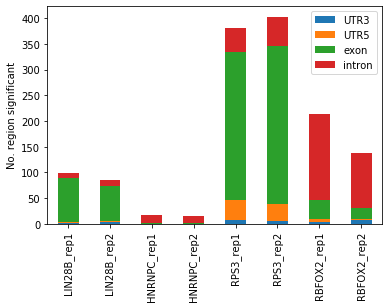

In [30]:
no_signi.fillna(0).plot.bar(stacked = True)
plt.ylabel('No. region significant')

In [31]:
comp = no_signi.fillna(0)
comp = comp.div(comp.sum(axis = 1), axis = 0)

Text(0, 0.5, '% region')

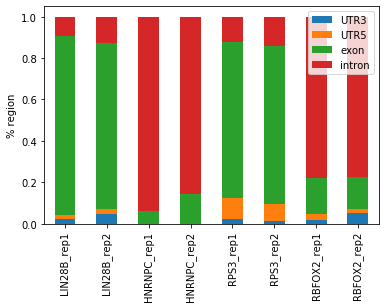

In [32]:
comp.plot.bar(stacked = True)
plt.ylabel('% region')